In [1]:
print("Building of the offline dataset")

Building of the offline dataset


In [2]:
# ============================================================================
# CELL 0 : SETUP - PHASE 3A (REVISED)
# ============================================================================

import os
import sys
from pathlib import Path
import numpy as np
import torch

os.chdir('/workspaces/energy-rl-project')
sys.path.insert(0, '/workspaces/energy-rl-project/src')

os.environ['EPLUS_PATH'] = '/usr/local/EnergyPlus-24-2-0'

# ⭐ SET SEED FOR REPRODUCIBILITY
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import shutil

from src.config import DATA_RAW_DIR, DATA_OFFLINE_DIR, RESULTS_LOGS_DIR, RESULTS_FIGURES_DIR
from src.environments import BuildingBatteryEnv
from src.algorithms.offline_replay_buffer import OfflineReplayBuffer, save_statistics
from src.algorithms.policies_helper import RuleBasedPolicy, get_mixed_policy_action, get_policy_distribution

print("✅ Setup Phase 3A (REVISED) terminé")
print(f"   Working dir: {os.getcwd()}")
print(f"   Offline dataset dir: {DATA_OFFLINE_DIR}")
print(f"   SEED: {SEED} (reproducibilité garantie)")

Couldn't import dot_parser, loading of dot files will not be possible.
[CONFIG] Sinergym logs directory: /workspaces/energy-rl-project/data/raw
✅ Setup Phase 3A (REVISED) terminé
   Working dir: /workspaces/energy-rl-project
   Offline dataset dir: /workspaces/energy-rl-project/data/offline_dataset
   SEED: 42 (reproducibilité garantie)


In [3]:
# ============================================================================
# CELL 1 : GÉNÉRER 200 EPISODES (DATASET MIXTE : 70% RANDOM + 20% RULE + 10% EXPERT)
# ============================================================================

print("=" * 80)
print("📊 PHASE 3A (REVISED) : Offline Dataset Generation")
print("=" * 80)
print()

# ⭐ CONFIGURATION AMÉLIORÉE
NUM_EPISODES = 200  # ⬆️ AUGMENTÉ de 20 à 200
MAX_STEPS_PER_EPISODE = 250
TARGET_TRANSITIONS = 50000  # ⭐ 10x plus que avant

# Buildings à alterner (au lieu de juste "hot")
BUILDINGS = [
    'Eplus-5zone-hot-continuous-v1',
    'Eplus-5zone-cool-continuous-v1',
    'Eplus-5zone-mixed-continuous-v1',
]

# Buffer
buffer = OfflineReplayBuffer(max_size=100000)

# ⭐ POLITIQUE MIXTE
mix_ratios = {'random': 0.7, 'rule': 0.2, 'expert': 0.1}
policy_distribution = get_policy_distribution(NUM_EPISODES, mix_ratios)
print(f"🎲 Policy distribution:")
print(f"   Random: {sum(1 for p in policy_distribution if p == 'random')} episodes (70%)")
print(f"   Rule-based: {sum(1 for p in policy_distribution if p == 'rule')} episodes (20%)")
print(f"   Expert: {sum(1 for p in policy_distribution if p == 'expert')} episodes (10%)")
print(f"\n🏢 Buildings: {BUILDINGS}")
print()

# Logs
log_file = RESULTS_LOGS_DIR / 'phase_3a_offline.log'
with open(log_file, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write(f"Phase 3A (REVISED) : Offline Dataset Generation\n")
    f.write(f"Start: {datetime.now()}\n")
    f.write(f"SEED: {SEED}\n")
    f.write(f"Target transitions: {TARGET_TRANSITIONS}\n")
    f.write(f"Mix: {mix_ratios}\n")
    f.write("=" * 80 + "\n\n")

# Observation/action stats (pour normalisation)
obs_list = []
action_list = []
reward_list = []

# Boucle sur les episodes
for ep_num in range(NUM_EPISODES):
    policy_type = policy_distribution[ep_num]
    building_id = BUILDINGS[ep_num % len(BUILDINGS)]  # ⭐ Alterner les buildings
    
    print(f"Episode {ep_num + 1}/{NUM_EPISODES} - Policy: {policy_type:6s} - Building: {building_id.split('-')[1]}")
    
    # ⭐ CRÉER UN NOUVEL ENV À CHAQUE EPISODE
    try:
        base_env = gym.make(building_id, seed=SEED + ep_num)  # ⭐ Seed unique par episode
        
        wrapped_env = BuildingBatteryEnv(
            env=base_env,
            battery_capacity=10.0,
            battery_efficiency=0.9,
            battery_power_max=5.0,
            soc_min=0.2,
            soc_max=0.9,
            pv_max_power=5.0,
            pv_efficiency=0.2,
            price_on_peak=0.25,
            price_off_peak=0.10,
            comfort_temp_range=(21.0, 25.0),
            lambda_comfort=1.0,
            lambda_battery=0.1
        )
    except Exception as e:
        print(f"   ❌ Erreur création env: {e}")
        continue
    
    # Créer rule-based policy pour cet episode
    rule_policy = RuleBasedPolicy(wrapped_env.action_space)
    
    # Reset
    try:
        obs, info = wrapped_env.reset()
    except Exception as e:
        print(f"   ❌ Erreur reset: {e}")
        wrapped_env.close()
        base_env.close()
        continue
    
    # Episode loop
    episode_transitions = 0
    episode_reward = 0
    
    for step in range(MAX_STEPS_PER_EPISODE):
        # ⭐ SÉLECTIONNER ACTION SELON POLICY_TYPE
        action = get_mixed_policy_action(
            policy_type,
            obs,
            info,
            wrapped_env.action_space,
            rule_policy,
            expert_agent=None  # Pour l'instant, pas d'expert (créé en Phase 3B)
        )
        
        try:
            next_obs, reward, terminated, truncated, info = wrapped_env.step(action)
            done = terminated or truncated
            
            # ⭐ CLAMP REWARDS pour stabilité
            reward_clipped = np.clip(reward, -10.0, 0.0)  # Clamp à [-10, 0]
            
            # Ajouter au buffer
            buffer.add(obs, action, reward_clipped, next_obs, done, info)
            
            # ⭐ COLLECTE POUR NORMALISATION
            obs_list.append(obs)
            action_list.append(action)
            reward_list.append(reward_clipped)
            
            episode_transitions += 1
            episode_reward += reward_clipped
            
            obs = next_obs
            
            if done:
                break
        
        except Exception as e:
            print(f"   ⚠️ Step {step}: {str(e)[:50]}")
            break
    
    print(f"   ✅ {episode_transitions} transitions (reward: {episode_reward:.2f})")
    
    # Log
    with open(log_file, 'a') as f:
        f.write(f"Episode {ep_num + 1} ({policy_type}): {episode_transitions} transitions, reward: {episode_reward:.2f}\n")
    
    # ⭐ CLEANUP AMÉLIORÉ : Supprimer AUSSI ce qui est à la racine
    print(f"   🧹 Cleanup Eplus...")
    eplus_dirs = list(Path('/workspaces/energy-rl-project').glob('Eplus-*-res*'))
    for dir_path in eplus_dirs:
        try:
            dest = DATA_RAW_DIR / dir_path.name
            shutil.rmtree(str(dir_path))  # ⭐ SUPPRIMER la source aussi
            print(f"      ✅ Supprimé: {dir_path.name}")
        except Exception as e:
            print(f"      ⚠️ Erreur cleanup {dir_path.name}: {e}")
    
    # Fermer env
    try:
        wrapped_env.close()
        base_env.close()
    except:
        pass

print()
print("=" * 80)
print(f"✅ Offline dataset generated!")
print(f"   Total transitions: {len(buffer)}")
print(f"   Target was: {TARGET_TRANSITIONS}")
print(f"   Progress: {len(buffer) / TARGET_TRANSITIONS * 100:.1f}%")
print("=" * 80)

# Log final
with open(log_file, 'a') as f:
    f.write(f"\nTotal transitions: {len(buffer)}\n")
    f.write(f"End: {datetime.now()}\n")

📊 PHASE 3A (REVISED) : Offline Dataset Generation

🎲 Policy distribution:
   Random: 140 episodes (70%)
   Rule-based: 40 episodes (20%)
   Expert: 20 episodes (10%)

🏢 Buildings: ['Eplus-5zone-hot-continuous-v1', 'Eplus-5zone-cool-continuous-v1', 'Eplus-5zone-mixed-continuous-v1']

Episode 1/200 - Policy: random - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 2/200 - Policy: random - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.55%/s, 2% completed]      ✅ 250 transitions (reward: -350.41)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.65%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 6/200 - Policy: random - Building: 5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.79%/s, 2% completed]      ✅ 250 transitions (reward: -612.20)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.63%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 7/200 - Policy: random - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.27%/s, 2% completed]      ✅ 250 transitions (reward: -368.50)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.47%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 8/200 - Policy: rule   - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:26,  3.66%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<00:50,  1.94%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 10/200 - Policy: random - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.97%/s, 2% completed]      ✅ 250 transitions (reward: -352.54)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.09%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 11/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 19.02%/s, 2% completed]      ✅ 250 transitions (reward: -408.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.43%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 12/200 - Policy: expert - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 20.49%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 22.01%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 11.66%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 14/200 - Policy: random - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-coo

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.56%/s, 2% completed]      ✅ 250 transitions (reward: -311.88)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.96%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 15/200 - Policy: expert - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 21.02%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 11.25%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 16/200 - Policy: rule   - Building: 5zone
#=

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.12%/s, 2% completed]     ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.36%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 17/200 - Policy: random - Building: 5zone
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.94%/s, 2% completed]      ✅ 250 transitions (reward: -375.24)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.22%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 18/200 - Policy: rule   - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.57%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:15,  6.21%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 19/200 - Policy: random - Building: 5zone
#=

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 19.96%/s, 2% completed]      ✅ 250 transitions (reward: -422.66)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.40%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 21/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.70%/s, 2% completed]      ✅ 250 transitions (reward: -557.81)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:27,  3.57%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 22/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 24.27%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.67%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 24/200 - Policy: random - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.60%/s, 2% completed]      ✅ 250 transitions (reward: -585.95)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.05%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 25/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.66%/s, 2% completed]      ✅ 250 transitions (reward: -327.21)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.29%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 26/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.04%/s, 2% completed]      ✅ 250 transitions (reward: -328.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.21%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 27/200 - Policy: random - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.26%/s, 2% completed]      ✅ 250 transitions (reward: -615.41)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.19%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 28/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 11.67%/s, 2% completed]      ✅ 250 transitions (reward: -334.73)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.23%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 29/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.40%/s, 2% completed]      ✅ 250 transitions (reward: -322.15)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.33%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 30/200 - Policy: random - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.77%/s, 2% completed]      ✅ 250 transitions (reward: -621.29)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.74%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 31/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.60%/s, 2% completed]      ✅ 250 transitions (reward: -356.90)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:16,  5.88%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 32/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.37%/s, 2% completed]      ✅ 250 transitions (reward: -398.19)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.39%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 33/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.07%/s, 2% completed]      ✅ 250 transitions (reward: -595.77)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.66%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 34/200 - Policy: random - Building: 5zone
#==

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.63%/s, 2% completed]      ✅ 250 transitions (reward: -481.68)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.21%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 35/200 - Policy: rule   - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 22.56%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.68%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 36/200 - Policy: random - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.20%/s, 2% completed]      ✅ 250 transitions (reward: -662.01)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.41%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 37/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.08%/s, 2% completed]      ✅ 250 transitions (reward: -359.95)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:15,  6.24%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 38/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.73%/s, 2% completed]      ✅ 250 transitions (reward: -337.91)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.36%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 39/200 - Policy: rule   - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.60%/s, 2% completed]      ✅ 250 transitions (reward: -486.15)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.49%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 41/200 - Policy: random - Building: 5zone
#=====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.71%/s, 2% completed]      ✅ 250 transitions (reward: -307.72)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-cont

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.18%/s, 2% completed]      ✅ 250 transitions (reward: -350.20)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  8.10%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 44/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.87%/s, 2% completed]      ✅ 250 transitions (reward: -308.40)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.42%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 45/200 - Policy: random - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.22%/s, 2% completed]      ✅ 250 transitions (reward: -649.00)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  8.04%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 46/200 - Policy: expert - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.13%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.06%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 47/200 - Policy: random - Building: 5zone
#=====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 19.22%/s, 2% completed]      ✅ 250 transitions (reward: -296.21)
   🧹

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.90%/s, 2% completed]      ✅ 250 transitions (reward: -575.30)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.70%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 49/200 - Policy: rule   - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.16%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.16%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 50/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.20%/s, 2% completed]      ✅ 250 transitions (reward: -397.47)
   🧹

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.13%/s, 2% completed]      ✅ 250 transitions (reward: -579.24)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.39%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 52/200 - Policy: rule   - Building: 5zone
#==

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.20%/s, 2% completed]      ✅ 250 transitions (reward: -319.54)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.41%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 54/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.58%/s, 2% completed]      ✅ 250 transitions (reward: -546.93)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.49%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 55/200 - Policy: random - Building: 5zone
#==

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.80%/s, 2% completed]      ✅ 250 transitions (reward: -359.92)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:17,  5.69%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 56/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.48%/s, 2% completed]      ✅ 250 transitions (reward: -276.93)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.39%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 57/200 - Policy: rule   - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.12%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  8.01%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 58/200 - Policy: random - Building: 5zone
#=

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.61%/s, 2% completed]      ✅ 250 transitions (reward: -395.94)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.54%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 59/200 - Policy: rule   - Building: 5zone
#=====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 21.24%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 11.43%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 60/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.09%/s, 2% completed]      ✅ 250 transitions (reward: -652.72)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.59%/s, 2% complete

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 21.17%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 11.21%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 62/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.12%/s, 2% completed]      ✅ 250 transitions (reward: -339.84)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09,  9.81%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 63/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.76%/s, 2% completed]      ✅ 250 transitions (reward: -683.29)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.81%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 64/200 - Policy: random - Building: 5zone
#==

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.04%/s, 2% completed]      ✅ 250 transitions (reward: -292.17)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.47%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 65/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.37%/s, 2% completed]      ✅ 250 transitions (reward: -396.83)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.51%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 66/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.15%/s, 2% completed]      ✅ 250 transitions (reward: -538.95)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.84%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 67/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.24%/s, 2% completed]      ✅ 250 transitions (reward: -307.06)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.81%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 68/200 - Policy: expert - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 20.41%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.17%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 69/200 - Policy: random - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.46%/s, 2% completed]      ✅ 250 transitions (reward: -622.98)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.85%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 70/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  8.93%/s, 2% completed]      ✅ 250 transitions (reward: -390.19)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:19,  5.05%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 71/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.86%/s, 2% completed]      ✅ 250 transitions (reward: -446.17)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.62%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 72/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.75%/s, 2% completed]      ✅ 250 transitions (reward: -673.45)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.57%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 73/200 - Policy: rule   - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 19.28%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.43%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 74/200 - Policy: random - Building: 5zone
#=====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 19.12%/s, 2% completed]      ✅ 250 transitions (reward: -360.47)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.10%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 75/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.01%/s, 2% completed]      ✅ 250 transitions (reward: -542.68)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.77%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 76/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.08%/s, 2% completed]      ✅ 250 transitions (reward: -391.63)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:31,  3.12%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 77/200 - Policy: random - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-coo

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.45%/s, 2% completed]      ✅ 250 transitions (reward: -404.19)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.96%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 78/200 - Policy: random - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 19.19%/s, 2% completed]      ✅ 250 transitions (reward: -722.56)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09,  9.96%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 79/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.27%/s, 2% completed]      ✅ 250 transitions (reward: -434.28)
   🧹 Cleanup Eplus...
      ✅

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.31%/s, 2% completed]      ✅ 250 transitions (reward: -392.21)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.75%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 81/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.59%/s, 2% completed]      ✅ 250 transitions (reward: -505.91)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.54%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 82/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.80%/s, 2% completed]      ✅ 250 transitions (reward: -288.19)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.61%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 83/200 - Policy: random - Building: 5zone
#=====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.60%/s, 2% completed]      ✅ 250 transitions (reward: -392.34)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.54%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 84/200 - Policy: expert - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 21.15%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.41%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 85/200 - Policy: expert - Building: 5zone
#=

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.58%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.27%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 86/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 11.74%/s, 2% completed]      ✅ 250 transitions (reward: -452.23)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.64%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 87/200 - Policy: rule   - Building: 5

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 20.25%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.78%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 88/200 - Policy: random - Building: 5zone
#=

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.59%/s, 2% completed]      ✅ 250 transitions (reward: -393.65)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  8.92%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 89/200 - Policy: expert - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.26%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.04%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 90/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.28%/s, 2% completed]      ✅ 250 transitions (reward: -541.33)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.35%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 91/200 - Policy: random - Building: 5zone
#==============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.23%/s, 2% completed]      ✅ 250 transitions (reward: -359.24)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.57%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 92/200 - Policy: rule   - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 20.40%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.63%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 93/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.85%/s, 2% completed]      ✅ 250 transitions (reward: -659.20)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.76%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 94/200 - Policy: random - Building: 5zone
#==

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.98%/s, 2% completed]      ✅ 250 transitions (reward: -362.72)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.67%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 95/200 - Policy: random - Building: 5zone
#=====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.65%/s, 2% completed]      ✅ 250 transitions (reward: -332.66)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  8.08%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 96/200 - Policy: expert - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 19.40%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09,  9.99%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 97/200 - Policy: rule   - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.12%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.89%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 98/200 - Policy: random - Building: 5zone
#=================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 19.08%/s, 2% completed]      ✅ 250 transitions (reward: -352.29)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.23%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 99/200 - Policy: random - Building: 5zone
#======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.88%/s, 2% completed]      ✅ 250 transitions (reward: -588.29)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:24,  4.06%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 100/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.79%/s, 2% completed]      ✅ 250 transitions (reward: -398.35)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:16,  6.10%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 101/200 - Policy: random - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.09%/s, 2% completed]      ✅ 250 transitions (reward: -315.08)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.55%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 102/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.58%/s, 2% completed]      ✅ 250 transitions (reward: -655.28)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.57%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 103/200 - Policy: rule   - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymna

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 12.03%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.69%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 104/200 - Policy: rule   - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.99%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.44%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 105/200 - Policy: random - Building: 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.48%/s, 2% completed]      ✅ 250 transitions (reward: -525.89)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:27,  3.54%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 106/200 - Policy: rule   - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.21%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.39%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 107/200 - Policy: random - Building: 5zone
#====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.81%/s, 2% completed]      ✅ 250 transitions (reward: -314.08)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.61%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 108/200 - Policy: random - Building: 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.61%/s, 2% completed]      ✅ 250 transitions (reward: -565.38)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.74%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 109/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.51%/s, 2% completed]      ✅ 250 transitions (reward: -315.97)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:15,  6.32%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 110/200 - Policy: rule   - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.00%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.39%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 111/200 - Policy: rule   - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 20.27%/s, 2% completed]     ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.46%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 112/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.03%/s, 2% completed]      ✅ 250 transitions (reward: -371.09)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.18%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 113/200 - Policy: expert - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 20.16%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 10.96%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 114/200 - Policy: rule   - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 20.64%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 11.21%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 115/200 - Policy: random - Building: 5zone
#============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.09%/s, 2% completed]      ✅ 250 transitions (reward: -403.93)
   🧹 Cleanup Eplus...
      ✅

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.49%/s, 2% completed]      ✅ 250 transitions (reward: -328.59)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:15,  6.35%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 117/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.06%/s, 2% completed]      ✅ 2

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.94%/s, 2% completed]      ✅ 250 transitions (reward: -379.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.35%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 119/200 - Policy: rule   - Building: 5zone
#====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.33%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.79%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 120/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09,  9.92%/s, 2% completed]      ✅ 250 transitions (reward: -559.03)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:16,  5.82%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 121/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.47%/s, 2% completed]      ✅ 250 transitions (reward: -308.94)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.64%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 122/200 - Policy: random - Building: 5zone
#====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.22%/s, 2% completed]      ✅ 250 transitions (reward: -401.76)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.55%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 123/200 - Policy: rule   - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.77%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.26%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 124/200 - Policy: rule   - Building: 5zone
#============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.86%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.50%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 125/200 - Policy: random - Building: 5zone
#====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.67%/s, 2% completed]      ✅ 250 transitions (reward: -398.60)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.24%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 126/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.56%/s, 2% completed]      ✅ 250 transitions (reward: -494.68)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:19,  5.13%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 127/200 - Policy: expert - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 20.84%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.56%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 128/200 - Policy: rule   - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 19.10%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.42%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 129/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.34%/s, 2% completed]      ✅ 250 transitions (reward: -592.28)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  8.05%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environmen

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.27%/s, 2% completed]      ✅ 250 transitions (reward: -444.02)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.47%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 131/200 - Policy: rule   - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.15%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.59%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 132/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.27%/s, 2% completed]      ✅ 250 transitions (reward: -519.44)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.29%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 133/200 - Policy: random - Building: 5zone
#=

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 12.01%/s, 2% completed]      ✅ 250 transitions (reward: -359.50)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.31%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 134/200 - Policy: rule   - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.59%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.35%/s, 2% completed]      ✅ 250 transitions (reward: -507.84)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:23,  4.17%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 136/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.18%/s, 2% completed]      ✅ 250 transitions (reward: -466.40)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.22%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 137/200 - Policy: random - Building: 5zone
#====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.30%/s, 2% completed]      ✅ 250 transitions (reward: -295.45)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.79%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 138/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.21%/s, 2% completed]      ✅ 250 transitions (reward: -591.33)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.93%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 139/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.07%/s, 2% completed]      ✅ 250 transitions (reward: -329.07)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.70%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 140/200 - Policy: random - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 10.97%/s, 2% completed]      ✅ 250 transitions (reward: -390.62)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.56%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 141/200 - Policy: expert - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.69%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.15%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 142/200 - Policy: rule   - Building: 5zone
#============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 21.00%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 10.90%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 143/200 - Policy: expert - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.16%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.73%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 144/200 - Policy: random - Building: 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.16%/s, 2% completed]      ✅ 250 transitions (reward: -555.42)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.62%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 145/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.27%/s, 2% completed]      ✅ 250 transitions (reward: -382.40)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.33%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 146/200 - Policy: random - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 11.84%/s, 2% completed]      ✅ 250 transitions (reward: -329.47)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:15,  6.49%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 147/200 - Policy: random - Building: 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulati

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.92%/s, 2% completed]      ✅ 250 transitions (reward: -379.32)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:35,  2.77%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 149/200 - Policy: random - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-co

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.82%/s, 2% completed]      ✅ 250 transitions (reward: -321.08)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.67%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 150/200 - Policy: random - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.30%/s, 2% completed]      ✅ 250 transitions (reward: -598.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.53%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 151/200 - Policy: rule   - Building: 5zone
#=

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 19.58%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.44%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 152/200 - Policy: expert - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 19.76%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.13%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 153/200 - Policy: random - Building: 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.62%/s, 2% completed]      ✅ 250 transitions (reward: -553.84)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:15,  6.13%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 154/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.76%/s, 2% completed]      ✅ 250 transitions (reward: -311.48)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.22%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 155/200 - Policy: random - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:16,  5.90%/s, 2% completed]      ✅ 250 transitions (reward: -293.76)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:23,  4.24%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 156/200 - Policy: random - Building: 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.18%/s, 2% completed]      ✅ 250 transitions (reward: -539.02)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.06%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 157/200 - Policy: rule   - Building: 5zone
#=

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.85%/s, 2% completed]      ✅ 250 transitions (reward: -385.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.47%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 159/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.74%/s, 2% completed]      ✅ 250 transitions (reward: -526.04)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.39%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 160/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.



[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.70%/s, 2% completed]      ✅ 250 transitions (reward: -372.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:15,  6.53%/s, 2% completed]
[ENVIRONMENT]

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.47%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.41%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 162/200 - Policy: random - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zon

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.29%/s, 2% completed]      ✅ 250 transitions (reward: -607.22)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.66%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 163/200 - Policy: rule   - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 19.83%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.65%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 164/200 - Policy: expert - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.86%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.58%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 165/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 12.19%/s, 2% completed]      ✅ 250 transitions (reward: -618.33)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.74%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 166/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.06%/s, 2% completed]      ✅ 250 transitions (reward: -362.47)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.27%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 167/200 - Policy: random - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.35%/s, 2% completed]      ✅ 250 transitions (reward: -336.64)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.20%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 168/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.58%/s, 2% completed]      ✅ 250 transitions (reward: -624.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.83%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 169/200 - Policy: expert - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.46%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.01%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 170/200 - Policy: random - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.59%/s, 2% completed]      ✅ 250 transitions (reward: -359.99)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.67%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 171/200 - Policy: random - Building: 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 12.14%/s, 2% completed]      ✅ 250 transitions (reward: -507.22)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.05%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 172/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.94%/s, 2% completed]      ✅ 250 transitions (reward: -323.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.89%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 173/200 - Policy: random - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 19.66%/s, 2% completed]      ✅ 250 transitions (reward: -329.54)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.34%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 174/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.31%/s, 2% completed]      ✅ 250 transitions (reward: -698.26)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.45%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 175/200 - Policy: rule   - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 20.15%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 10.95%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 176/200 - Policy: expert - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.08%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.48%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 177/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.56%/s, 2% completed]      ✅ 250 transitions (reward: -687.28)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.40%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 178/200 - Policy: random - Building: 5zone
#=

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 12.00%/s, 2% completed]      ✅ 250 transitions (reward: -286.85)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.69%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 179/200 - Policy: rule   - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 20.75%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.48%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 180/200 - Policy: expert - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09,  9.82%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:17,  5.60%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 181/200 - Policy: random - Building: 5zone
#============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.69%/s, 2% completed]      ✅ 250 transitions (reward: -346.66)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  8.06%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 183/200 - Policy: rule   - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 21.55%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 11.21%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 184/200 - Policy: random - Building: 5zone
#============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.97%/s, 2% completed]      ✅ 250 transitions (reward: -404.25)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  8.01%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 185/200 - Policy: rule   - Building: 5zone
#====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 18.46%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:10,  9.71%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 186/200 - Policy: random - Building: 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 12.79%/s, 2% completed]      ✅ 250 transitions (reward: -607.93)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.65%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 187/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.47%/s, 2% completed]      ✅ 250 transitions (reward: -332.63)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:13,  7.53%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 188/200 - Policy: random - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.54%/s, 2% completed]      ✅ 250 transitions (reward: -347.76)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.38%/s, 2%

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.47%/s, 2% completed]      ✅ 250 transitions (reward: -519.07)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:19,  5.05%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 190/200 - Policy: random - Building: 5zone
#=

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 16.19%/s, 2% completed]      ✅ 250 transitions (reward: -413.48)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.38%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 191/200 - Policy: random - Building: 5zone
#====================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 16.34%/s, 2% completed]      ✅ 250 transitions (reward: -416.07)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.48%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 192/200 - Policy: expert - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.40%/s, 2% completed]      ✅ 250 transitions (reward: -1225.36)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.26%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 193/200 - Policy: random - Building: 5zone
#============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 14.93%/s, 2% completed]      ✅ 250 transitions (reward: -371.43)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.99%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 194/200 - Policy: expert - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:04, 19.91%/s, 2% completed]      ✅ 250 transitions (reward: -846.13)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:09, 10.83%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 195/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:06, 15.88%/s, 2% completed]      ✅ 250 transitions (reward: -575.65)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-mixed-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.63%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 196/200 - Policy: random - Building: 5zone
#=============================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:08, 11.68%/s, 2% completed]      ✅ 250 transitions (reward: -338.09)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:14,  6.55%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 197/200 - Policy: random - Building: 5zone
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-co

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:05, 17.17%/s, 2% completed]      ✅ 250 transitions (reward: -355.96)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:11,  8.84%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 198/200 - Policy: random - Building: 5zone
#=====================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.79%/s, 2% completed]      ✅ 250 transitions (reward: -523.11)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-hot-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  7.60%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 200/200 - Policy: random - Building: 5zone
#================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:07, 13.43%/s, 2% completed]      ✅ 250 transitions (reward: -397.95)
   🧹 Cleanup Eplus...
      ✅ Supprimé: Eplus-5zone-cool-continuous-v1-res1
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:00<00:12,  8.08%/s, 2% completed]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]

✅ Offline dataset generated!
   Total transitions: 50000
   Target was: 50000
   Progres

Program terminated: EnergyPlus Terminated--Error(s) Detected.


In [4]:
# ============================================================================
# CELL 2 : NORMALISER DATASET ET SAUVEGARDER
# ============================================================================

print("\n" + "=" * 80)
print("📊 NORMALISATION ET SAUVEGARDE")
print("=" * 80)

# ⭐ CALCULER STATS POUR NORMALISATION
print(f"\n📈 Calculating normalization statistics...")

obs_array = np.array(obs_list)
action_array = np.array(action_list)
reward_array = np.array(reward_list)

obs_mean = obs_array.mean(axis=0)
obs_std = obs_array.std(axis=0)
obs_std = np.where(obs_std < 1e-6, 1.0, obs_std)  # Éviter division par 0

action_mean = action_array.mean(axis=0)
action_std = action_array.std(axis=0)
action_std = np.where(action_std < 1e-6, 1.0, action_std)

reward_mean = reward_array.mean()
reward_std = reward_array.std()

print(f"   Obs mean: {obs_mean[:3]}...")  # Afficher les 3 premiers
print(f"   Obs std: {obs_std[:3]}...")
print(f"   Action mean: {action_mean}")
print(f"   Action std: {action_std}")
print(f"   Reward mean: {reward_mean:.4f}")
print(f"   Reward std: {reward_std:.4f}")

# ⭐ NORMALISER LE BUFFER
print(f"\n📝 Normalizing buffer transitions...")
normalized_obs_list = [(obs - obs_mean) / obs_std for obs in obs_list]
normalized_action_list = [(action - action_mean) / action_std for action in action_list]

# Recréer buffer avec données normalisées
normalized_buffer = OfflineReplayBuffer(max_size=100000)
for i, (norm_obs, norm_action, reward, _) in enumerate(
    zip(normalized_obs_list, normalized_action_list, reward_array, range(len(buffer)))
):
    # Récupérer next_obs et done de l'ancien buffer
    next_obs = normalized_obs_list[i + 1] if i + 1 < len(buffer) else norm_obs
    done = buffer.dones[i]
    
    normalized_buffer.add(norm_obs, norm_action, reward, next_obs, done)

print(f"   ✅ Normalized {len(normalized_buffer)} transitions")

# Paths
dataset_path = DATA_OFFLINE_DIR / 'offline_dataset.pkl'
stats_path = DATA_OFFLINE_DIR / 'dataset_stats.json'
norm_path = DATA_OFFLINE_DIR / 'normalization_stats.json'

# Sauvegarder buffer normalisé
print(f"\n💾 Saving normalized buffer...")
normalized_buffer.save(str(dataset_path))

# Calculer et sauvegarder stats (sur données normalisées)
print(f"📊 Computing final statistics...")
stats = normalized_buffer.get_statistics()

print(f"\n📈 Final Statistics:")
print(f"   Num transitions: {stats['num_transitions']}")
print(f"   Reward mean: {stats['reward_mean']:.4f}")
print(f"   Reward std: {stats['reward_std']:.4f}")
print(f"   Reward min: {stats['reward_min']:.4f}")
print(f"   Reward max: {stats['reward_max']:.4f}")
print(f"   Obs shape: {stats['obs_shape']}")
print(f"   Action shape: {stats['action_shape']}")

save_statistics(stats, str(stats_path))

# ⭐ SAUVEGARDER NORMALIZATION STATS (pour dénormaliser plus tard si besoin)
normalization_stats = {
    'obs_mean': obs_mean.tolist(),
    'obs_std': obs_std.tolist(),
    'action_mean': action_mean.tolist(),
    'action_std': action_std.tolist(),
    'reward_mean': float(reward_mean),
    'reward_std': float(reward_std),
}
save_statistics(normalization_stats, str(norm_path))

print(f"\n✅ Dataset sauvegardé:")
print(f"   {dataset_path}")
print(f"   {stats_path}")
print(f"   {norm_path}")
print("=" * 80)


📊 NORMALISATION ET SAUVEGARDE

📈 Calculating normalization statistics...
   Obs mean: [ 1.     1.848 10.4  ]...
   Obs std: [1.         0.7699974  6.69925369]...
   Action mean: [15.941596   25.621176   -0.06227136]
   Action std: [3.7438564  2.2493742  0.72728086]
   Reward mean: -2.2603
   Reward std: 3.0490

📝 Normalizing buffer transitions...
   ✅ Normalized 50000 transitions

💾 Saving normalized buffer...
✅ Buffer saved to /workspaces/energy-rl-project/data/offline_dataset/offline_dataset.pkl
📊 Computing final statistics...

📈 Final Statistics:
   Num transitions: 50000
   Reward mean: -2.2603
   Reward std: 3.0490
   Reward min: -10.0000
   Reward max: -0.0028
   Obs shape: (18,)
   Action shape: (3,)
✅ Statistics saved to /workspaces/energy-rl-project/data/offline_dataset/dataset_stats.json
✅ Statistics saved to /workspaces/energy-rl-project/data/offline_dataset/normalization_stats.json

✅ Dataset sauvegardé:
   /workspaces/energy-rl-project/data/offline_dataset/offline_dataset


📊 VISUALISATION DES STATISTIQUES

✅ Figure saved: phase_3a_dataset_stats.png


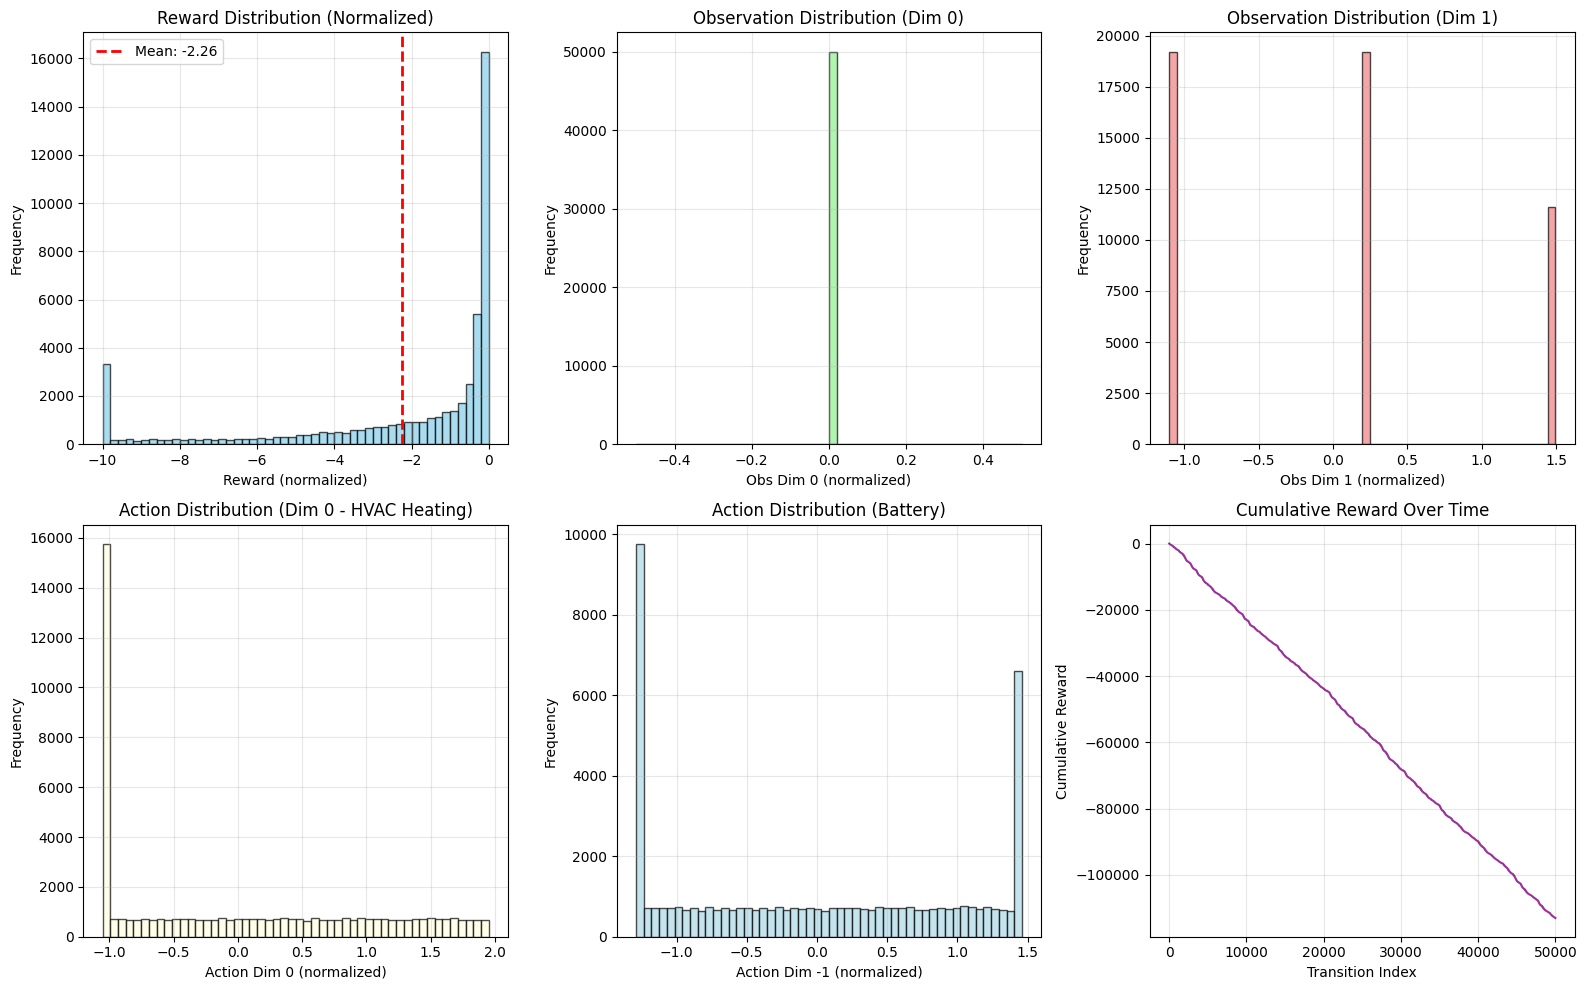


✅ PHASE 3A TERMINÉE
   Dataset: 50000 transitions (NORMALIZED)
   Saved to: /workspaces/energy-rl-project/data/offline_dataset/offline_dataset.pkl
   Normalization stats: /workspaces/energy-rl-project/data/offline_dataset/normalization_stats.json


In [5]:
# ============================================================================
# CELL 3 : VISUALISER LES STATISTIQUES
# ============================================================================

%matplotlib inline

print("\n" + "=" * 80)
print("📊 VISUALISATION DES STATISTIQUES")
print("=" * 80)

# Extraire les données (du buffer normalisé)
obs_norm, actions_norm, rewards_norm, _, _ = normalized_buffer.get_all()

# Créer les graphiques
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Reward distribution
axes[0, 0].hist(rewards_norm.flatten(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(rewards_norm.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rewards_norm.mean():.2f}')
axes[0, 0].set_xlabel('Reward (normalized)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Reward Distribution (Normalized)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Observation dim 0 (temperature)
axes[0, 1].hist(obs_norm[:, 0], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Obs Dim 0 (normalized)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Observation Distribution (Dim 0)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Observation dim 1 (zone temp)
if obs_norm.shape[1] > 1:
    axes[0, 2].hist(obs_norm[:, 1], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[0, 2].set_xlabel('Obs Dim 1 (normalized)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Observation Distribution (Dim 1)')
    axes[0, 2].grid(True, alpha=0.3)

# 4. Action dim 0 (HVAC heating)
axes[1, 0].hist(actions_norm[:, 0], bins=50, color='lightyellow', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Action Dim 0 (normalized)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Action Distribution (Dim 0 - HVAC Heating)')
axes[1, 0].grid(True, alpha=0.3)

# 5. Action dim -1 (Battery)
axes[1, 1].hist(actions_norm[:, -1], bins=50, color='lightblue', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Action Dim -1 (normalized)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Action Distribution (Battery)')
axes[1, 1].grid(True, alpha=0.3)

# 6. Cumulative reward
cumsum_rewards = np.cumsum(rewards_norm.flatten())
axes[1, 2].plot(cumsum_rewards, color='purple', linewidth=1.5, alpha=0.8)
axes[1, 2].set_xlabel('Transition Index')
axes[1, 2].set_ylabel('Cumulative Reward')
axes[1, 2].set_title('Cumulative Reward Over Time')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_FIGURES_DIR / 'phase_3a_dataset_stats.png', dpi=150, bbox_inches='tight')
print("\n✅ Figure saved: phase_3a_dataset_stats.png")
plt.show()

print("\n" + "=" * 80)
print(f"✅ PHASE 3A TERMINÉE")
print(f"   Dataset: {len(normalized_buffer)} transitions (NORMALIZED)")
print(f"   Saved to: {dataset_path}")
print(f"   Normalization stats: {norm_path}")
print("=" * 80)